In [1]:
from PIL import Image
import requests
from io import BytesIO
from map_boxes import mean_average_precision_for_boxes
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
from matplotlib.colors import ListedColormap
import matplotlib
import tqdm
import os

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [17]:
GT_JSON = '../dataset/train.json' # 기본 json
PRED_CSV = '../sample_submission/train_sample.csv'
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

In [18]:
'''
[
    [file_name 1, label_index, x_min, x_max, y_min, y_max], 
]
'''   
coco = COCO(GT_JSON) # 형식

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [19]:
'''
    GT_JSON: valid set json file path
    현재 예시에서는 train.json을 임의로 valid set으로 사용
    PRED_CSV: 위의 valid set을 inference한 submission file
'''
# load ground truth
with open(GT_JSON, 'r') as outfile:
    gt_json = (json.load(outfile))
# with open(GT_plus_json, 'w') as outfile:
#     json.dump(data, outfile)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as img
import matplotlib.colors as mcolors
image_dir = '../dataset/'
colorlist = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FFFF','#0000FF','#7F00FF','#FF00FF','#FF007F']

# image 출력    
def plot(id,box):
    image_info = coco.loadImgs(id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    fig, ax =plt.subplots()
    img_test = img.imread(image_dir+image_info['file_name'])
    ax.imshow(img_test)
    if box ==True:
        for i in range(len(annotation_info_list)):
            for j in range(10):
                if annotation_info_list[i]['category_id']==j:
                    rect = patches.Rectangle((annotation_info_list[i]['bbox'][0], annotation_info_list[i]['bbox'][1]), annotation_info_list[i]['bbox'][2], annotation_info_list[i]['bbox'][3], linewidth=1, edgecolor=colorlist[j], facecolor='none')
                    ax.add_patch(rect)
                    plt.annotate(LABEL_NAME[annotation_info_list[i]['category_id']],[annotation_info_list[i]['bbox'][0],annotation_info_list[i]['bbox'][1]-15],color=colorlist[j], fontweight='bold')
    else:
         pass
    #plt.axis([0,image_info['width'],0,image_info['height']])
    plt.title(f'image_id : {id}')
    plt.show()

In [6]:
from PIL import Image
# 이미지 잘라서 저장
def cut_bbox(id,label_num):
    save_dir = "../"+LABEL_NAME[label_num]+"/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    count =1
    image_info = coco.loadImgs(id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    img_test = Image.open(image_dir+image_info['file_name'])
    for i in range(len(annotation_info_list)):
        if annotation_info_list[i]['category_id']==label_num:
            xmin, w, ymin, h = annotation_info_list[i]['bbox'][0], annotation_info_list[i]['bbox'][2], annotation_info_list[i]['bbox'][1], annotation_info_list[i]['bbox'][3]
            cropped_image = img_test.crop((xmin,ymin,xmin+w,ymin+h))
            #cropped_image = cropped_image.resize((int(cropped_image.width)/2),int(cropped_image.height/2))
            filename = LABEL_NAME[label_num]+'_'+str(count)+'.jpg'
            # 파일명이 중복되지 않을 때까지 고유 번호 증가
            while os.path.exists(os.path.join(save_dir, filename)):
                count += 1
                filename = LABEL_NAME[label_num]+"_" + str(count) + ".jpg"
            
            # 이미지 저장
            cropped_image.save(os.path.join(save_dir, filename))
        
            # 고유 번호 증가
            count += 1

In [7]:
# for image_id in coco.getImgIds():
#     cut_bbox(image_id,0) id 1063 오류  
#     cut_bbox(image_id,2)
#     cut_bbox(image_id,3)
#     cut_bbox(image_id,4)
#     cut_bbox(image_id,5)
#     cut_bbox(image_id,6)
#     cut_bbox(image_id,0)
#     cut_bbox(image_id,8)
#     cut_bbox(image_id,9)
#     

In [8]:
# 각 이미지별 annotation 저장
def anno(class_name,label_num):
    for image_id in coco.getImgIds():
        image_info = coco.loadImgs(image_id)[0]
        annotation_id = coco.getAnnIds(imgIds=image_info['id'])
        annotation_info_list = coco.loadAnns(annotation_id)
        img_test = Image.open(image_dir+image_info['file_name'])
        for i in range(len(annotation_info_list)):
            if annotation_info_list[i]['category_id']==label_num:
                xmin, w, ymin, h = annotation_info_list[i]['bbox'][0], annotation_info_list[i]['bbox'][2], annotation_info_list[i]['bbox'][1], annotation_info_list[i]['bbox'][3]
                class_name.append((image_id,w,h))
    return class_name

In [9]:
a=[]
b=[]
c=[]
d=[]
e=[]
f=[]
g=[]
paperpack = anno(a,2)
metal = anno(b,3)
glass = anno(c,4)
plastic = anno(d,5)
styrofoam = anno(e,6)
battery = anno(f,8)
cloth = anno(g,9)

In [13]:
# 이미지 붙이기
def paste_image(gt_json, annotation,base_id,label_num,direction,size):
    gt_json = gt_json #기본 gt json
    anno = annotation 
    r= np.random.randint(1,len(anno),1) #각 이미지 아이디 랜덤으로 뽑기
    image_info = coco.loadImgs(base_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)

    image_dir = '/opt/ml/dataset_'+str(size)+'/'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

    img2_dir = "../"+LABEL_NAME[label_num]+"/"
    image1 = Image.open(image_dir+image_info['file_name'])
    image2 = Image.open(img2_dir+LABEL_NAME[label_num]+'_'+str(r[0])+'.jpg')
    image2 = image2.resize((int(image2.width/size),int(image2.height/size)))

    if direction== 'left_up':
        bbox=[float(0), float(0), anno[r[0]-1][1]/size, anno[r[0]-1][2]/size]
    elif direction == 'left_down':
        bbox=[float(0), 1024-(anno[r[0]-1][2]/size), anno[r[0]-1][1]/size, anno[r[0]-1][2]/size]
    elif direction =='right_up':
        bbox=[1024-(anno[r[0]-1][1]/size), float(0),anno[r[0]-1][1]/size, anno[r[0]-1][2]/size]
    elif direction == 'right_down':
        bbox = [1024-(anno[r[0]-1][1]/size), 1024-(anno[r[0]-1][2]/size), anno[r[0]-1][1]/size, anno[r[0]-1][2]/size]
    gt_json['annotations'].append({
    'image_id': base_id,
    'category_id': label_num,
    'area': np.round(anno[r[0]-1][1]*anno[r[0]-1][2]/(size**2),2),
    'bbox': bbox,
    'iscrowd': 0,
    'id': 9
    })
    image1.paste(image2, (int(bbox[0]), int(bbox[1])))
    image1.save(image_dir+image_info['file_name'])

In [14]:
for image_id in coco.getImgIds()[:698]:
     paste_image(gt_json, cloth,image_id,9,'left_up',size=2)
     paste_image(gt_json, battery,image_id,8,'left_down',size=2)
     paste_image(gt_json, metal,image_id,3,'right_up',size=2)
     paste_image(gt_json, glass,image_id,4,'right_down',size=2)
for image_id in coco.getImgIds()[698:698*2]:
     paste_image(gt_json, metal,image_id,3,'left_up',size=2)
     paste_image(gt_json, cloth,image_id,9,'left_down',size=2)
     paste_image(gt_json, battery,image_id,8,'right_up',size=2)
     paste_image(gt_json, glass,image_id,4,'right_down',size=2)
for image_id in coco.getImgIds()[698*2:698*3]:
     paste_image(gt_json, styrofoam,image_id,6,'left_up',size=2)
     paste_image(gt_json, paperpack,image_id,2,'left_down',size=2)
     paste_image(gt_json, cloth,image_id,9,'right_up',size=2)
     paste_image(gt_json, battery,image_id,8,'right_down',size=2)
for image_id in coco.getImgIds()[698*3:698*4]:
     paste_image(gt_json, paperpack,image_id,2,'left_up',size=2)
     paste_image(gt_json, battery,image_id,8,'left_down',size=2)
     paste_image(gt_json, plastic,image_id,5,'right_up',size=2)
     paste_image(gt_json, cloth,image_id,9,'right_down',size=2)
for image_id in coco.getImgIds()[698*4:698*5]:
     paste_image(gt_json, cloth,image_id,9,'left_up',size=2)
     paste_image(gt_json, metal,image_id,3,'left_down',size=2)
     paste_image(gt_json, battery,image_id,8,'right_up',size=2)
     paste_image(gt_json, paperpack,image_id,2,'right_down',size=2)
for image_id in coco.getImgIds()[698*5:698*6]:
     paste_image(gt_json, paperpack,image_id,2,'left_up',size=2)
     paste_image(gt_json, cloth,image_id,9,'left_down',size=2)
     paste_image(gt_json, glass,image_id,4,'right_up',size=2)
     paste_image(gt_json, metal,image_id,3,'right_down',size=2)
for image_id in coco.getImgIds()[698*6:]:
     paste_image(gt_json, battery,image_id,8,'left_up',size=2)
     paste_image(gt_json, styrofoam,image_id,6,'left_down',size=2)
     paste_image(gt_json, styrofoam,image_id,6,'right_up',size=2)
     paste_image(gt_json, glass,image_id,4,'right_down',size=2)

In [15]:
# annotation id 추가 후 json 파일 저장
gt_json['annotations'].sort(key=lambda x:x['image_id'])

for i in range(len(gt_json['annotations'])):
    gt_json['annotations'][i]['id']=i

file_path = '/opt/ml/dataset_2/train_new.json'
with open(file_path, 'w') as outfile:
    json.dump(gt_json, outfile)

### 코드 실행 결과 확인

In [18]:
coco = COCO(file_path)
max = 0
sum = 0
class_dict ={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    
    if len(annotation_info_list) > max:
        max = len(annotation_info_list)
    sum += len(annotation_info_list)
    for i in range(len(annotation_info_list)):
            for j in range(10):
                if annotation_info_list[i]['category_id']==j:
                     class_dict[j] +=1

print('이미지 사이즈:','[',image_info['width'],',',image_info['height'],']') 
print('이미지 클래스 개수:', len(LABEL_NAME))
print('각 클래스별 개수: ',class_dict)     
print('한 이미지의 최대 박스개수 : ',max)
print('전체 박스 개수: ', sum)


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
이미지 사이즈: [ 1024 , 1024 ]
이미지 클래스 개수: 10
각 클래스별 개수:  {0: 3966, 1: 6352, 2: 3689, 3: 3728, 4: 3771, 5: 3641, 6: 3351, 7: 5178, 8: 4344, 9: 4656}
한 이미지의 최대 박스개수 :  75
전체 박스 개수:  42676


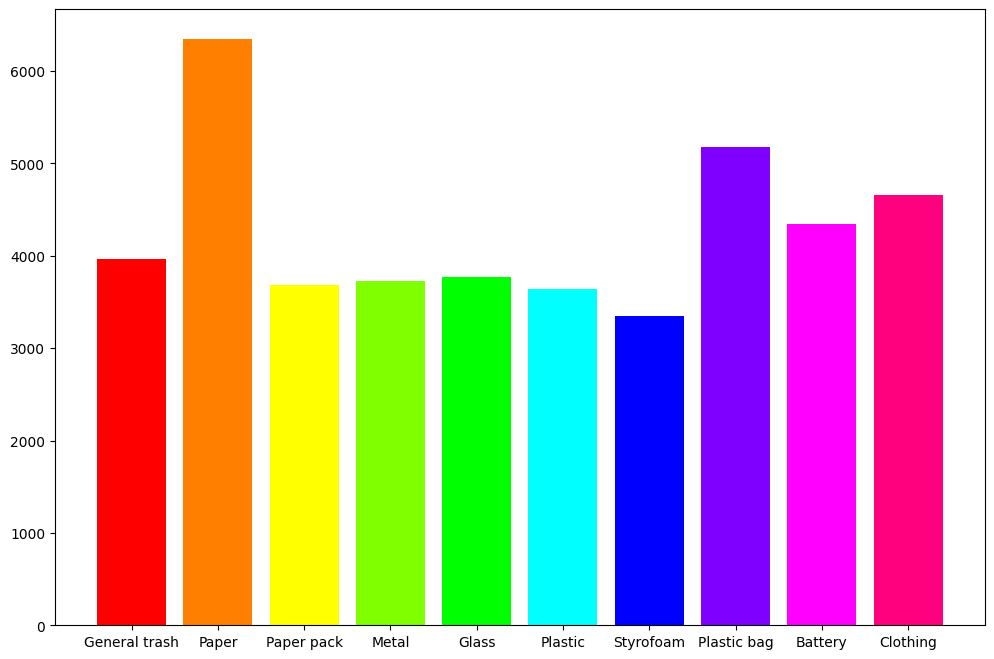

In [19]:
plt.figure(figsize=(12, 8))
plt.bar(LABEL_NAME, class_dict.values(), color= colorlist)
plt.show()

In [22]:
def plot(id,box):
    image_info = coco.loadImgs(id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    fig, ax =plt.subplots()
    img_test = img.imread('/opt/ml/dataset_2/'+image_info['file_name'])
    ax.imshow(img_test)
    if box ==True:
        for i in range(len(annotation_info_list)):
            for j in range(10):
                if annotation_info_list[i]['category_id']==j:
                    rect = patches.Rectangle((annotation_info_list[i]['bbox'][0], annotation_info_list[i]['bbox'][1]), annotation_info_list[i]['bbox'][2], annotation_info_list[i]['bbox'][3], linewidth=1, edgecolor=colorlist[j], facecolor='none')
                    ax.add_patch(rect)
                    plt.annotate(LABEL_NAME[annotation_info_list[i]['category_id']],[annotation_info_list[i]['bbox'][0],annotation_info_list[i]['bbox'][1]-15],color=colorlist[j], fontweight='bold')
    else:
         pass
    #plt.axis([0,image_info['width'],0,image_info['height']])
    plt.title(f'image_id : {id}')
    plt.show()

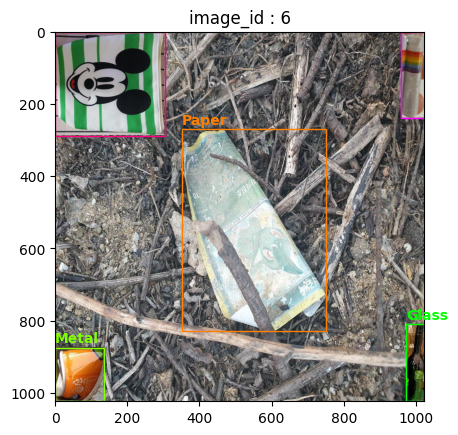

In [23]:
plot(6,box=True)

In [24]:
for i in range(len(gt_json['annotations'])):
    if gt_json['annotations'][i]['image_id'] ==0:
        print(gt_json['annotations'][i])

{'image_id': 0, 'category_id': 0, 'area': 257301.66, 'bbox': [197.6, 193.7, 547.8, 469.7], 'iscrowd': 0, 'id': 0}
{'image_id': 0, 'category_id': 9, 'area': 9763.3, 'bbox': [0.0, 0.0, 109.7, 89.0], 'iscrowd': 0, 'id': 1}
{'image_id': 0, 'category_id': 8, 'area': 16253.6, 'bbox': [936.0, 0.0, 88.0, 184.7], 'iscrowd': 0, 'id': 2}
{'image_id': 0, 'category_id': 3, 'area': 22251.18, 'bbox': [0.0, 834.95, 117.7, 189.05], 'iscrowd': 0, 'id': 3}
{'image_id': 0, 'category_id': 4, 'area': 26162.5, 'bbox': [874.5, 849.0, 149.5, 175.0], 'iscrowd': 0, 'id': 4}


In [ ]:
for i in range(len(gt_json['annotations'])):
    if gt_json['annotations'][i]['iscrowd'] !=0:
        print(1)